#### Text Classification: Multiclass

This is a continuation of the previous notebook, but without a tutorial as an extra assignment. MultiClass classification on Stack Overflow data

In [1]:
import matplotlib.pyplot as plt
import os
import re
import shutil
import string
import tensorflow as tf

from tensorflow.keras import layers, losses

2023-12-15 09:34:20.663530: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-12-15 09:34:20.688196: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-15 09:34:20.688217: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-15 09:34:20.689135: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-15 09:34:20.693638: I tensorflow/core/platform/cpu_feature_guar

In [3]:
DATAPTH = '../data'
url = "https://storage.googleapis.com/download.tensorflow.org/data/stack_overflow_16k.tar.gz"

dataset = tf.keras.utils.get_file("so_16k", url, untar=True, cache_dir=DATAPTH, cache_subdir='so_16k')


6053168/6053168 [==============================] - 1s 0us/step


In [5]:
dataset_dir = os.path.join(os.path.dirname(dataset))
os.listdir(dataset_dir)

['train', 'test', 'so_16k.tar.gz', 'README.md']

In [6]:
train_dir = os.path.join(dataset_dir, 'train')
os.listdir(train_dir)

['javascript', 'python', 'csharp', 'java']

In [7]:
sample_file = os.path.join(train_dir, 'java/100.txt')
with open(sample_file) as f:
    print(f.read())

"how many objects are created in inheritance? if only one then how parent class constructor gets executed when sub class object is create....class parent.{. parent(). {.  system.out.println(""parent class construcor"");. }.}.class child extends parent .{. child(). {.  system.out.println(""child class construcor"");. }. .}. class test. {.  public static void main(string a[]).  {.   child obj = new child();.  }. }"



In [12]:
batch_size = 32
seed = 1234

raw_train_ds = tf.keras.utils.text_dataset_from_directory(
    DATAPTH + '/so_16k/train',
    batch_size=batch_size,
    validation_split = 0.2,
    subset='training',
    seed = seed
)

Found 8000 files belonging to 4 classes.
Using 6400 files for training.


In [13]:
for text_batch, label_batch in raw_train_ds.take(1):
    for i in range(10):
        print("Review", text_batch.numpy()[i])
        print('Label', label_batch.numpy()[i])

Review b'"the recursive method is getting into deadloop i am writing a simple crawler based on htmlagilitypack and fizzler, in order to check if a keyword is contained anywhere on the webpage and it\'s corresponding sublinks. then the same procedure is repeated for all of the sublinks up to 50 level deep. so that the number grows exponentially. ..the issue is that i wanted to convert the method that i have written to a recursive one, but it doesn\'t work - gets stuck after first link, as well as works really slow...this is what i\'ve done currently:..    public static void getalllinks(htmlweb web, list&lt;string&gt; relevantlinks, string inputlink).    {.        string mainlink = ""http://www.cnet.com"";.        console.writeline(""current count of links: "" + relevantlinks.count + ""tcurrent link: "" + inputlink);...        htmldocument html = web.load(inputlink);.        htmldocument htmlinner = new htmldocument();..        html.documentnode.descendants().            .where(n =&gt; n

In [23]:
raw_val_ds = tf.keras.utils.text_dataset_from_directory(
    DATAPTH + '/so_16k/train',
    batch_size=batch_size,
    validation_split=0.2,
    subset='validation',
    seed=seed
)

Found 8000 files belonging to 4 classes.
Using 1600 files for validation.


In [15]:
raw_test_ds = tf.keras.utils.text_dataset_from_directory(
    DATAPTH + '/so_16k/test',
    batch_size=batch_size
)

Found 8000 files belonging to 4 classes.


In [16]:
# This dataset shouldn't have HTML tags, but I'll copy the code anyway

def custom_standardization(input_data):
    lower = tf.strings.lower(input_data)
    stripped_html = tf.strings.regex_replace(lower, '<br />', ' ')
    return tf.strings.regex_replace(stripped_html,
                                    '[%s]' % re.escape(string.punctuation),
                                    '')

In [32]:
max_features = 15000
sequence_length = 300

vectorize_layer = layers.TextVectorization(
    standardize=custom_standardization,
    max_tokens=max_features,
    output_mode='int',
    output_sequence_length=sequence_length
)

In [33]:
train_text = raw_train_ds.map(lambda x,y: x)
vectorize_layer.adapt(train_text)

In [34]:
def vectorize_text(text, label):
    text = tf.expand_dims(text, -1)
    return vectorize_layer(text), label

In [35]:
text_batch, label_batch = next(iter(raw_train_ds))
first_review, first_label = text_batch[0], label_batch[0]
print('Review', first_review)
print('Label', raw_train_ds.class_names[first_label])
print('Vectorized Review', vectorize_text(first_review, first_label))

Review tf.Tensor(b'"understanding the expression (value, othervalue) i found this in a blank test..how come (1,4) returns 4 ?..what is going on in that expression ?..would someone have a link to the doc concerning it ?"\n', shape=(), dtype=string)
Label javascript
Vectorized Review (<tf.Tensor: shape=(1, 300), dtype=int64, numpy=
array([[ 934,    2,  652,   49,    1,    3,  229,   13,    7,    5,   16,
           1,  684,  739,  235,  150,   54,    6,  425,   37,    7,   14,
         652,   65,  282,   17,    5,  450,    4,    2, 1131, 8176,   10,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
  

In [36]:
for i in range(250):
    item = vectorize_text(first_review, first_label)[0][0][i]
    value = tf.keras.backend.get_value(item)
    if value == 0:
        continue
    print(value, " --->", vectorize_layer.get_vocabulary()[value])
print('Vocabulary Size: ', len(vectorize_layer.get_vocabulary()))


934  ---> understanding
2  ---> the
652  ---> expression
49  ---> value
1  ---> [UNK]
3  ---> i
229  ---> found
13  ---> this
7  ---> in
5  ---> a
16  ---> blank
1  ---> [UNK]
684  ---> come
739  ---> 14
235  ---> returns
150  ---> 4
54  ---> what
6  ---> is
425  ---> going
37  ---> on
7  ---> in
14  ---> that
652  ---> expression
65  ---> would
282  ---> someone
17  ---> have
5  ---> a
450  ---> link
4  ---> to
2  ---> the
1131  ---> doc
8176  ---> concerning
10  ---> it
Vocabulary Size:  15000


In [37]:
train_ds = raw_train_ds.map(vectorize_text)
val_ds = raw_val_ds.map(vectorize_text)
test_ds = raw_test_ds.map(vectorize_text)

In [38]:
train_ds = raw_train_ds.map(vectorize_text)
val_ds = raw_val_ds.map(vectorize_text)
test_ds = raw_test_ds.map(vectorize_text)

In [79]:
embedding_dim = 64
model = tf.keras.Sequential([
    layers.Embedding(max_features, embedding_dim), # takes integer encoded reviews and looks ip and embedding vector for each word-index
    layers.Dropout(0.2),
    layers.SeparableConv1D(filters=32,
                           kernel_size=3,
                           activation='relu',
                           padding='same'),
    layers.SeparableConv1D(filters=32,
                           kernel_size=3,
                           activation='relu',
                           padding='same'),
    layers.MaxPooling1D(3),
    layers.GlobalAveragePooling1D(), # returns fixed length ouput vector for each example by averaging over the sequence dimension
    layers.Dropout(0.2),
    layers.Dense(4)
])
model.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_12 (Embedding)    (None, None, 64)          960000    
                                                                 
 dropout_26 (Dropout)        (None, None, 64)          0         
                                                                 
 separable_conv1d_13 (Separ  (None, None, 32)          2272      
 ableConv1D)                                                     
                                                                 
 separable_conv1d_14 (Separ  (None, None, 32)          1152      
 ableConv1D)                                                     
                                                                 
 max_pooling1d_5 (MaxPoolin  (None, None, 32)          0         
 g1D)                                                            
                                                     

In [80]:
callbacks = [tf.keras.callbacks.EarlyStopping(
        monitor='val_loss', patience=3)]
model.compile(loss=losses.SparseCategoricalCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
              metrics=['accuracy'])

In [81]:
epochs = 50
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
    callbacks=callbacks
)

Epoch 1/50


200/200 [==============================] - 12s 55ms/step - loss: 1.3863 - accuracy: 0.2444 - val_loss: 1.3862 - val_accuracy: 0.2694
Epoch 2/50
200/200 [==============================] - 6s 30ms/step - loss: 1.3861 - accuracy: 0.2745 - val_loss: 1.3860 - val_accuracy: 0.2750
Epoch 3/50
200/200 [==============================] - 4s 22ms/step - loss: 1.3857 - accuracy: 0.2991 - val_loss: 1.3856 - val_accuracy: 0.2881
Epoch 4/50
200/200 [==============================] - 3s 15ms/step - loss: 1.3849 - accuracy: 0.3137 - val_loss: 1.3844 - val_accuracy: 0.3088
Epoch 5/50
200/200 [==============================] - 2s 10ms/step - loss: 1.3827 - accuracy: 0.3294 - val_loss: 1.3814 - val_accuracy: 0.3338
Epoch 6/50
200/200 [==============================] - 3s 13ms/step - loss: 1.3757 - accuracy: 0.3609 - val_loss: 1.3718 - val_accuracy: 0.3575
Epoch 7/50
200/200 [==============================] - 2s 10ms/step - loss: 1.3566 - accuracy: 0.3830 - val_loss: 1.3464 - val_accuracy: 0.3906
Epoch 8/5

No matter what I do in this simple paradigm, I'm stuck at around 76% validation accuracy. There's some obvious overfitting going on here that I can't seem to overcome

In [82]:
loss, accuracy = model.evaluate(test_ds)
print('Loss: ', loss)
print('Accuracy: ', accuracy)

  1/250 [..............................] - ETA: 13s - loss: 0.5013 - accuracy: 0.7188

250/250 [==============================] - 1s 3ms/step - loss: 0.6671 - accuracy: 0.7425
Loss:  0.6671305894851685
Accuracy:  0.7425000071525574


In [83]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

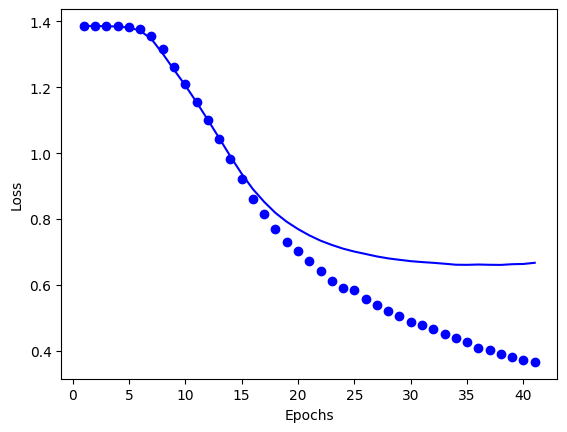

In [84]:
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc)+1)

plt.plot(epochs, loss, 'bo', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')

plt.show()

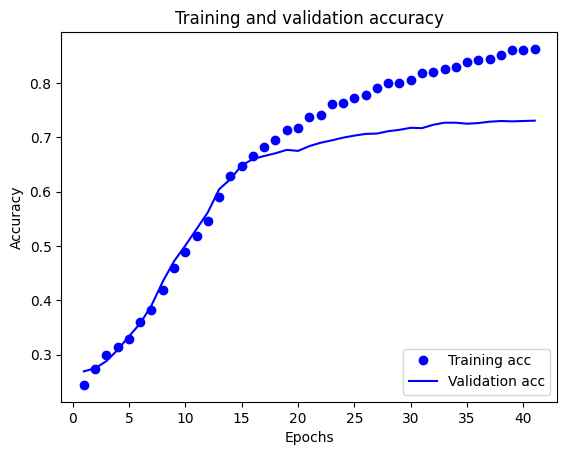

In [85]:
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.show()